In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline

In [3]:
# =============================================================================
# Constants and conversion factors : 
# =============================================================================

users = 324
cms_per_gpm = 6.309e-5
ns_per_s = 1e9
kg_per_lb = 0.453
s_per_interval = 30
s_per_hr = 3600
kwh_per_mwh = 1000
j_per_kj = 1000
ccf_to_therms = 1.037
emission_per_therm = 5.3 #(kg)
no_of_boilers = 2

In [4]:
# =============================================================================
# Water heater model definition : 
# =============================================================================

c_p = 4184                    # Units: J / kg / K
V = 0.151416                  # Units: m^3
rho = 1000                    # Units: kg / m^3
R = 900                       # Units: K / W  (divided by cross sectional area : 9/0.01)
T_out = 60 + 273.15           # Units: K
T_in = 20 + 273.15            # Units: K
T_o = 25 + 273.15
T_set = 60 + 273.15
K = 2 * 1e5
H_in = 1

def waterheater(t, T, H_in, Q):
    H_in = - K * (T - T_set)
    result = (H_in + (c_p * rho * Q(t) * T_in) + (T_o / R) - (1 / R + c_p * rho * Q(t)) * T) / (c_p * rho * V)
    return result 

def sol_func(time_start, time_end, Q):
    sol = scipy.integrate.solve_ivp(waterheater, [time_start, time_end],
                                    [T_out], args=(H_in, Q),
                                    method='LSODA', dense_output=True, max_step=600)
    return sol

In [5]:
# =============================================================================
# Import and read file:
# =============================================================================

SitesData = pd.read_csv("../data/site_c.csv")
Watttime = pd.read_csv("../data/ERCOT_EASTTX_MOER.csv")

# Convert timestamp strings to datetimes
SitesData['TimeStamp'] = pd.to_datetime(SitesData['TimeStamp'])
Watttime['timestamp_local'] = pd.to_datetime(Watttime['timestamp_local'])
Watttime['timestamp_utc'] = pd.to_datetime(Watttime['timestamp_utc'])

In [6]:
# =============================================================================
# Test for duplicate time indices:
# =============================================================================

assert not SitesData.duplicated(subset=['TimeStamp']).any()
assert not Watttime.duplicated(subset=['timestamp_utc']).any()

In [7]:
# =============================================================================
# Set time index
# =============================================================================

# Set indices to time index
SitesData.set_index('TimeStamp', inplace=True)
SitesData = SitesData.tz_localize('UTC')
Watttime.set_index('timestamp_utc', inplace=True)

# Sort time index
SitesData.sort_index(inplace=True)
Watttime.sort_index(inplace=True)

# Resample site data to 30s intervals
SitesData = SitesData.resample('30s').mean()

In [8]:
# =============================================================================
# Read Flow and time stamp columns:
# =============================================================================

flow_gpm = SitesData['FT1_GPM']

In [9]:
# =============================================================================
# Replacing erroneous negative flow values with zero:
# =============================================================================

flow_is_nan = flow_gpm.isnull()
flow_gpm.fillna(flow_gpm.mean(), inplace=True)  # Changed to mean
flow_gpm[flow_gpm < 0] = flow_gpm.mean()        # Changed to mean

In [10]:
# =============================================================================
# convert flow units and smooth:
# =============================================================================
flow_cms = flow_gpm * cms_per_gpm
flow_per_user_cms = flow_cms / users
flow_per_user_cms_rolling_mean = flow_per_user_cms.rolling(20, min_periods=1, center=True).mean()
flow_time_s = flow_per_user_cms_rolling_mean.index.astype(int).values / ns_per_s
flow_values_cms = flow_per_user_cms_rolling_mean.values

In [11]:
# =============================================================================
# Create function to interpolate flow:
# =============================================================================

time_start = flow_time_s.min()
time_end = flow_time_s.max()
Q = interp1d(flow_time_s,
             flow_values_cms,
             kind='cubic', fill_value=0.)

In [12]:
y = pd.Series(np.where(flow_is_nan, np.nan, Q(flow_time_s)),
              index=flow_per_user_cms_rolling_mean.index)

In [13]:
import matplotlib.dates as mdates

In [14]:
y_tz = y.tz_convert('America/Chicago')
idx = pd.date_range('1970-01-01 00:00', '1970-01-02 00:00', freq='h')

hours = np.arange(24)
hourly_mean = y_tz.groupby(y_tz.index.hour).mean()
hourly_5th_pct = y_tz.groupby(y_tz.index.hour).quantile(0.05)
hourly_95th_pct = y_tz.groupby(y_tz.index.hour).quantile(0.95)

cms_to_lpm = 1000 * 60

In [15]:
hours = np.asarray(hours.tolist() + [24])
hourly_mean = pd.concat([hourly_mean, hourly_mean[[0]]])
hourly_5th_pct = pd.concat([hourly_5th_pct, hourly_5th_pct[[0]]])
hourly_95th_pct = pd.concat([hourly_95th_pct, hourly_95th_pct[[0]]])

In [16]:
# Seasonal
y[y.index.month.isin([12, 1, 2])].mean() / y.mean(), y[y.index.month.isin([6, 7, 8])].mean() / y.mean()

(1.0651654748093544, 0.969130550452903)

In [17]:
# Hourly
hourly_mean[8] / hourly_mean.mean(), hourly_mean[20] / hourly_mean.mean()

(1.7222478941903554, 1.8269537129246616)

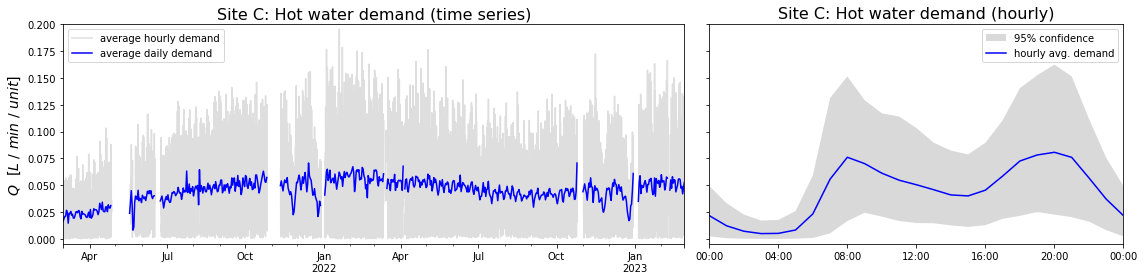

In [18]:
# =============================================================================
# Plotting:
# =============================================================================

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize=(16, 4))
(cms_to_lpm * y).resample('1h').mean().plot(ax=ax[0], color='0.75', alpha=0.5, label='average hourly demand')
(cms_to_lpm * y).resample('24h').mean().plot(ax=ax[0], color='b', label='average daily demand')
ax[1].fill_between(hours, (cms_to_lpm * hourly_95th_pct), (cms_to_lpm * hourly_5th_pct),
                   facecolor='0.85', label='95% confidence')
ax[1].plot(hours, (cms_to_lpm * hourly_mean), c='b', label='hourly avg. demand')
ax[0].set_ylabel('$Q \ \ [ L \ / \ min \ / \ unit ]$', size=14)
ax[0].set_xlabel('')
ax[0].set_title('Site C: Hot water demand (time series)', size=16)
ax[1].set_title('Site C: Hot water demand (hourly)', size=16)
ax[1].set_xticks(np.arange(0, 25, 4))
ax[1].set_xticklabels(idx[::4].strftime('%H:%M'))
ax[1].set_yticklabels('')
ax[0].set_ylim(-0.005, 0.2)
ax[1].set_ylim(-0.005, 0.2)
ax[0].set_xlim('20210301', '20230228')
ax[1].set_xlim(0, 24)
ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.savefig('../img/fig4_site_c.png', bbox_inches='tight', dpi=200)

In [19]:
(cms_to_lpm * y).mean()

0.04521016790017403

In [20]:
cwt_fahrenheit = SitesData['CWT']
cwt_celsius = 5 / 9 * (SitesData['CWT'] - 32)

#cwt_celsius = cwt_celsius.tz_localize('UTC')
cwt_celsius = cwt_celsius.tz_convert('America/Chicago')
idx = pd.date_range('1970-01-01 00:00', '1970-01-02 00:00', freq='h')

hours = np.arange(24)
hourly_med = cwt_celsius.groupby(cwt_celsius.index.hour).median()
hourly_5th_pct = cwt_celsius.groupby(cwt_celsius.index.hour).quantile(0.05)
hourly_95th_pct = cwt_celsius.groupby(cwt_celsius.index.hour).quantile(0.95)
hours = np.asarray(hours.tolist() + [24])
hourly_med = pd.concat([hourly_med, hourly_med[[0]]])
hourly_5th_pct = pd.concat([hourly_5th_pct, hourly_5th_pct[[0]]])
hourly_95th_pct = pd.concat([hourly_95th_pct, hourly_95th_pct[[0]]])

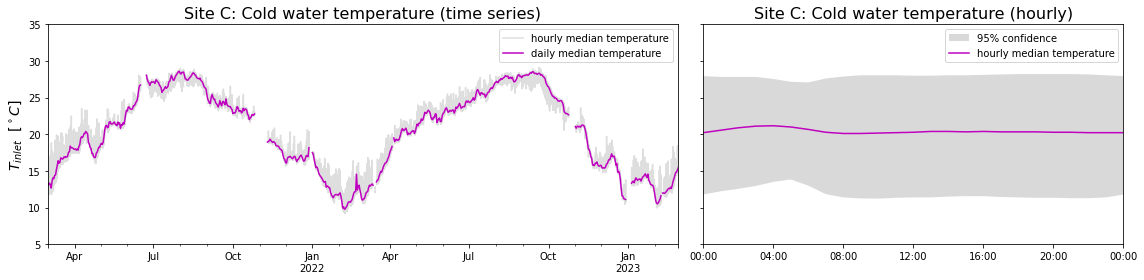

In [21]:
# =============================================================================
# Plotting:
# =============================================================================

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize=(16, 4))
(cwt_celsius).resample('1h').median().plot(ax=ax[0], color='0.75', alpha=0.5, label='hourly median temperature')
(cwt_celsius).resample('24h').median().plot(ax=ax[0], color='m', label='daily median temperature')
ax[1].fill_between(hours, (hourly_95th_pct), (hourly_5th_pct),
                   facecolor='0.85', label='95% confidence')
ax[1].plot(hours, (hourly_med), c='m', label='hourly median temperature')
ax[0].set_ylabel('$T_{inlet} \ \ [ ^\circ C ]$', size=14)
ax[0].set_xlabel('')
ax[0].set_title('Site C: Cold water temperature (time series)', size=16)
ax[1].set_title('Site C: Cold water temperature (hourly)', size=16)
ax[1].set_xticks(np.arange(0, 25, 4))
ax[1].set_xticklabels(idx[::4].strftime('%H:%M'))
ax[1].set_yticklabels('')
ax[0].set_ylim(5, 35)
ax[1].set_ylim(5, 35)
ax[0].set_xlim('20210301', '20230228')
ax[1].set_xlim(0, 24)
ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.savefig('../img/cwt_site_c.png', bbox_inches='tight', dpi=200)